# Boundary Relation Tests

## Setup

### Imports

In [1]:
from math import sqrt, pi

# Shared Packages
import pandas as pd
import numpy as np

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from metrics import *
from relations import *

### Global Settings

In [2]:
PRECISION = 2

In [3]:
%matplotlib inline

## Adjusting Boundary Slice Relations

For the beginning and ending slices of a structure the entire contour must
be treated as a boundary.  The structure does not have an interior on these
slices. In this case the “*Interior*” relations become “*Boundary*” relations.

The “*Interior*” bits of the DE-9IM relationship metric are combined with the 
“*Boundary*” bits using "OR" logic.  This will keep the “*Boundary*” bits as 
part of the boundary.


### Boundary Interpolation

- The last slice with a contour is not the actual boundary.  The boundary is
  half way between the last slice with a contour and the fist slice without a 
  contour.  
- The last slice is interpolated to create the boundary.
- The boundary slice index is half way between the two indexes (The mean).


#### Interpolation process
- Takes two polygons or one polygon an a "vanishing point" (The centroid of the polygon).
- Takes two SliceIndex values and calculates the mean as the new SliceIndex.
- For each coordinate point on the first polygon build a line from it to the 
  closest point on the second polygon.
- Return the half way point of this line as the new coordinate point.
- The new polygon is the set of all the new coordinate points.
_ To interpolate a polygon on a boundary slice, the centroid of the polygon is 
    used as the second point in the interpolation lines.
The Z value of the new point is the mean of the Z values of the two slices.


##### Simplest interpolation case

[(3.0, 3.0), (3.0, -3.0), (-3.0, -3.0), (-3.0, 3.0), (3.0, 3.0)]
[(-0.0, -0.0)]


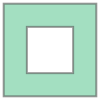

In [4]:
a1 = shapely.Polygon(box_points(6))
a2 = a1.centroid
print([c for c in a1.boundary.coords])
print([c for c in a2.coords])
new_cords = []
for crd in a1.boundary.coords:
    ln = shapely.LineString([a2, shapely.Point(crd)])
    ptn = ln.interpolate(0.5, normalized=True)
    new_cords.append(ptn.coords[0])
itp_poly = shapely.Polygon(new_cords)
a1 - itp_poly

##### Case 1: Two polygons

[(3.0, 3.0), (3.0, -3.0), (-3.0, -3.0), (-3.0, 3.0), (3.0, 3.0)]
[(2.0, 2.0), (2.0, -2.0), (-2.0, -2.0), (-2.0, 2.0), (2.0, 2.0)]
[(2.5, 2.5), (2.5, -2.5), (-2.5, -2.5), (-2.5, 2.5), (2.5, 2.5)]


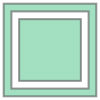

In [5]:
a1 = shapely.Polygon(box_points(6))
a2 = shapely.Polygon(box_points(4))
print([c for c in a1.boundary.coords])
print([c for c in a2.boundary.coords])
new_cords = []
for crd in a1.boundary.coords:
    ln = shapely.shortest_line(shapely.Point(crd), a2.boundary)
    ptn = ln.interpolate(0.5, normalized=True)
    new_cords.append(ptn.coords[0])
itp_poly = shapely.Polygon(new_cords)
print([c for c in itp_poly.boundary.coords])

shapely.union(a1 - itp_poly, a2)

##### General process

In [6]:
def interpolate_polygon(p1: shapely.Polygon,
                        p2: shapely.Polygon = None) -> shapely.Polygon:
    if p2 is None:
        boundary2 = p1.centroid
    else:
        boundary2 = p2.boundary
    new_cords = []
    for crd in p1.boundary.coords:
        ln = shapely.shortest_line(shapely.Point(crd), boundary2)
        ptn = ln.interpolate(0.5, normalized=True)
        new_cords.append(ptn)
    itp_poly = shapely.Polygon(new_cords)
    return itp_poly


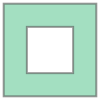

In [7]:
a1 = shapely.Polygon(box_points(6))
itp_poly = interpolate_polygon(a1)
a1-itp_poly

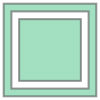

In [8]:
a1 = shapely.Polygon(box_points(6))
a2 = shapely.Polygon(box_points(4))
itp_poly = interpolate_polygon(a1, a2)
shapely.union(a1 - itp_poly, a2)

##### Update the z-coordinate of the polygon

In [9]:
slice_index=[1, 2]
new_z = np.mean(slice_index)
itp_poly = shapely.force_3d(itp_poly, new_z)

In [10]:
itp_poly.has_z

True

##### Final Function

In [11]:
def interpolate_polygon(slices: Union[List[SliceIndexType], SliceIndexType],
                        p1: shapely.Polygon,
                        p2: shapely.Polygon = None) -> shapely.Polygon:
    # If multiple slices given, calculate the new z value.
    if isinstance(slices, (list, tuple)):
        new_z = np.mean(slices)
    else:
        new_z = slices
    # If no second polygon given, use the centroid of the first polygon as the
    # boundary.
    if p2 is None:
        boundary2 = p1.centroid
    else:
        boundary2 = p2.boundary
    # Interpolate the new polygon coordinates as half way between the p1
    # boundary and boundary 2.
    new_cords = []
    for crd in p1.boundary.coords:
        ln = shapely.shortest_line(shapely.Point(crd), boundary2)
        ptn = ln.interpolate(0.5, normalized=True)
        new_cords.append(ptn)
    # Build the new polygon from the interpolated coordinates.
    itp_poly = shapely.Polygon(new_cords)
    # Add the z value to the polygon.
    itp_poly = shapely.force_3d(itp_poly, new_z)
    return itp_poly


### Boundary checks are done by *region* not by *structure*

- For all structures the `StructureSlice.contour` MultiPolygon for each slice 
    is separated into individual polygons and holes (Regions).
- Unique labels are applied to each region on the first slice: 'a', 'b' ...
- Overlapping polygons on the next slice are given the same region labels.
- If a polygon in the current region is not matched to a polygon in the next 
    region, it is a tagged as a “*Boundary*” polygon.
- If a polygon in the next region is not matched with a polygon in the current 
    region, it is tagged as a “*Boundary*” polygon and assigned a new unique 
    region label.
- In the case where two regions that converge into one the distinct region 
    labels are kept. This is because a polygon can be in multiple regions.
  


# Done to Here



Next Steps:
1. Use the `region_table` to identify boundaries for each region.
2. For each boundary, generate an interpolated boundary slice.
3. For each region in the other structure generate a corresponding interpolated 
    slice (if it exists).
4. Apply the DE-9IM logic to the boundary slices.
5. Modify the DE-9IM matrix to account for the boundary.
6. If the interpolated slice of the other structure is also a boundary slice, 
modify the DE-9IM matrix to account for this boundary as well.

In [12]:
def is_boundary(region):
    if isinstance(region, Region):
        return region.is_boundary
    return False


def is_hole(region):
    if isinstance(region, Region):
        return region.is_hole
    return False

def find_boundary_slices(region_table: pd.DataFrame, group_regions=False):
    has_boundary = region_table.map(is_boundary)
    boundaries = has_boundary.fillna(0).astype(bool)
    if group_regions:
        boundaries = has_boundary.stack('ROI', future_stack=True)
        boundaries = boundaries.apply(any, axis='columns')
        boundaries = boundaries.unstack('ROI')
    return boundaries

def has_neighbour(region_table: pd.DataFrame, offset: int):
    not_empty = region_table.map(empty_structure)
    neighbour = not_empty.shift(offset)
    neighbour['idx'] = neighbour.index.to_series().shift(1)
    neighbour.set_index('idx', append=True, inplace=True)
    return neighbour

def find_boundary_pairs(region_boundaries, neighbour_slice, selection):
    r_bdry = region_boundaries[selection]
    next_r = pd.DataFrame(neighbour_slice[selection])
    next_r = next_r.join(r_bdry, rsuffix='boundary')
    match = next_r.apply(all, axis='columns')
    boundary_pairs = list(next_r[match].index)
    return boundary_pairs

def match_interpolated_region(secondary: pd.DataFrame,
                              boundary_pair: Tuple[int, int]):
            # Matched Interpolated Secondary Slice
    s1 = secondary.at[boundary_pair[0], second_region]
    s2 = secondary.at[boundary_pair[1], second_region]
    if empty_structure(s1):
        if empty_structure(s2):
            si = np.nan
        else:
            si = interpolate_polygon(boundary_pair, s2.polygon)
    else:
        if empty_structure(s2):
            si = interpolate_polygon(boundary_pair, s1.polygon)
        else:
            si = interpolate_polygon(boundary_pair, s1.polygon, s2.polygon)
    return si


In [13]:
def parallel_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    left_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    right_middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)
    left_boundary_cylinder1 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=-0.4,
                                             spacing=slice_spacing)
    left_boundary_cylinder2 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=0.3,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, left_cylinder, right_cylinder,
                            right_middle_cylinder,
                            left_boundary_cylinder1,left_boundary_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


1. extract the regions for the first roi as primary and the regions for the second roi as secondary
2. find the boundaries for each region in the primary and secondary
3. loop through each primary region creating interpolated boundary slices
4. for both interpolated boundary slices in the region create a matching interpolated slice from reach secondary region
5. check whether the matching secondary is also a boundary
6. send the pair of regions to DE9IM to get the relationship making boundary adjustments for the primary or for both regions

In [14]:
slice_table = parallel_cylinders()
region_table = make_region_table(slice_table)
region_boundaries = find_boundary_slices(region_table)
next_slice = has_neighbour(region_table, 1)
prev_slice = has_neighbour(region_table, -1)

selected_roi = [1, 2]

In [15]:
struct_a, struct_b = selected_roi
primary = region_table[struct_a]
p_boundary = region_boundaries[struct_a]
secondary = region_table[struct_b]

for region in primary.columns:
    has_boundary = region_boundaries[(struct_a, region)]
    boundary_pairs = find_boundary_pairs(region_boundaries, next_slice,
                                         (struct_a, region))
    boundary_pairs.extend(find_boundary_pairs(region_boundaries, prev_slice,
                                              (struct_a, region)))
    boundary_relations = []
    for boundary_pair in boundary_pairs:
        p1 = primary.at[boundary_pair[0], region].polygon
        p_i = interpolate_polygon(boundary_pair, p1)
        for second_region in secondary.columns:
            adjustments = ['boundary_a']
            # Matched Interpolated Secondary Slice
            si = match_interpolated_region(secondary, boundary_pair)
            # Check if the interpolated secondary slice is also a boundary
            if any(region_boundaries.loc[list(boundary_pair),
                                         (struct_b, second_region)]):
                adjustments.append('boundary_b')
            # Get boundary relation as a DE27IM object.
            boundary_relation = DE27IM(p_i, si, adjustments=adjustments)
            boundary_relations.append(boundary_relation)


# ERROR: Boundary relations are not being calculated correctly.  


In [16]:
boundary_relations

[<DE27IM>: 000011001000000000000000000, <DE27IM>: 000011011000000000000000000]

In [17]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = list(selected_slices.agg(relate_structures,
                                         structures=selected_roi,
                                         axis='columns'))
mid_relations.extend(boundary_relations)


In [18]:

merged_relations(mid_relations).identify_relation()

<RelationshipType.UNKNOWN: 999>

- For Holes need to use a variation on StructureSlice that has the hole as the contour, but uses the exterior and Hull from the parent structure.
- For Holes the `adjust_boundary_relation` function shifts the interior relation and flips the exterior.

In [19]:
def find_holes(region_table, holes, selected_roi)->List[ROI_Type]:
    use_roi = set()
    for idx in region_table.columns[holes]:
        if idx[0] in selected_roi:
            use_roi.add(idx[0])
    return list(use_roi)

In [20]:
use_roi = find_holes(region_table, holes, selected_roi)
hole_regions = region_table.loc[:,holes][use_roi]
hole_boundaries = find_boundary_slices(hole_regions)

NameError: name 'holes' is not defined

**Need to analyze each hole independently**

###### Inverted Next_slice required for holes

In [155]:
next_slice.map(lambda x: not x)

ROI             0      1             2      3       
Label           a      b      c      d      e      f
Slice idx                                           
-0.5  NaN   False  False  False  False  False  False
-0.4  -0.5   True  False  False  False  False  False
-0.3  -0.4   True  False  False  False   True  False
-0.2  -0.3   True  False  False  False   True  False
-0.1  -0.2   True   True   True   True  False  False
 0.0  -0.1   True   True   True   True  False  False
 0.1   0.0   True   True   True   True  False  False
 0.2   0.1   True   True   True   True  False  False
 0.3   0.2   True   True   True   True  False  False
 0.4   0.3   True  False  False  False  False   True

## Boundary Check process
1. Build slice table (index= slice, columns = ROI, Data= StructureSlice)
2. Select Primary & Secondary ROI
	- Slice range = Min(starting slice) to Max(ending slice)
3. Send all slices with both Primary and Secondary contours for standard relation testing 
4. Identify the boundary slices of the Primary and Secondary ROI
    - Boundary slices are slices that have a contour, but one of their neighbouring slices do not have a contour.
5. For each boundary slice of the Primary ROI identify the neighbouring slice(s) that do not have a primary.
6. For each of these neighbouring slices select a Secondary slice for boundary tests:
	- If the slice has a Secondary contour, select that Secondary slice.
	- If the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.
	- If neither the neighbouring slice nor the same slice as the Primary boundary have a Secondary contour, do not select a Secondary slice. Boundary testing is not required.
7. Test the relation between the boundary Primary and the selected Secondary.
8. Apply a Primary boundary shift to the relation results.
9. If the selected Secondary is also a Secondary boundary, apply a Secondary boundary shift as well.
10. Merge all results and reduce to single relation

### Managing holes
The boundaries of holes must also be checked
- `adjust_boundary_relation` will need to be updated to include `shift_type`s for holes:
     - *hole_in_a* 
     - *hole_in_b*
     - *hole_in_both*
- The *holes* `shift_type` shifts the interior relation to a boundary relation only for the *contour* part.  The *exterior* and *hull* relation parts are not shifted.

- The `boundary_match` and `match_neighbour_slices` functions will need to be updated to include the hole boundary tests.
  - For hole boundaries, select the neighboring slice (s) that *DO* have a hole contour.
  - The Secondary slice selection works as usual.
  

When hole boundaries are tested, only the "contour" “*Boundary*” bits of the 'a' 
structure DE-9IM relationship


relation (DE27IM_Type): A triplet numeric DE-9IM relationship metric.
        

shift_type (str, optional): The polygon(s) that are boundaries:
- 'a' indicates that the first (primary) polygon is at a boundary.
- 'b' indicates that the second (secondary) polygon is at a boundary.
- 'both' (The default) indicates that both polygons are at a boundary.
- 'hole_in_a' indicates that the first polygon is at a boundary with a hole.
- 'hole_in_b' indicates that the second polygon is at a boundary with a hole.

### secondary boundary tests
- Applies to the Secondary ROI in the same way as the Primary ROI.
- The `boundary_match` and `match_neighbour_slices` functions will need to be adjusted to work for secondary boundaries as well.

|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Borders          |  `FF*FT****`  |   `T*T*F*FF*`   | `*********` |
|Borders result   |  `000011001`  |   `000011001`   | `000011001` |
|Interior Borders |  `FF*FT****`  |   `T***T****`   | `*********` |
|Result           |  `111001001`  |   `111001001`   | `001011101` |
                
**BORDERS:** The two structures share a common exterior boundary.

**BORDERS_INTERIOR:** The two structures share a common boundary and one is within the other.
    


|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Overlaps         |  `T*T***T**`  |   `*********`   | `*********` |
|Overlaps result  |  `110010001`  |   `110010001`   | `110010001` |

                
**OVERLAPS:** The two structures share a common region.
    

![alt text](Images/DE-9IM.png)

![alt text](../reference/RelationshipTreeDiagram.svg)

## Test structures


#### Concentric cylinders starting on the same slice
  
<img src="Images\Boundaries\PartitionSup3D.png" alt="PartitionSup3D" style="height:50px;">
<img src="Images\Boundaries\PartitionSup2D.png" alt="PartitionSup2D" style="height:30px;">

In [6]:
def concentric_cylinders_same_start():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    sup_partition = make_vertical_cylinder(roi_num=2, radius=1, length=0.4,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, sup_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [19]:
def parallel_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    left_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    right_middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)
    left_boundary_cylinder1 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=-0.4,
                                             spacing=slice_spacing)
    left_boundary_cylinder2 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=0.2,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, left_cylinder, right_cylinder,
                            right_middle_cylinder,
                            left_boundary_cylinder1,left_boundary_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(dual_embedded_cylinder(), [1, 2]))


In [7]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # cylinder with interior borders
    confines_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # cylinder completely inside of a hole
    surrounds_cylinder = make_vertical_cylinder(roi_num=3, radius=1, length=0.3,
                                             offset_x=-2.5, offset_z=-0.1,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole,
                            confines_cylinder, surrounds_cylinder,
                            bordering_cylinder1, bordering_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#### Embedded boxes

![ContainsCubes](ContainsCubes.png)

In [8]:
def embedded_boxes():
    slice_spacing = 0.5
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                                spacing=slice_spacing)
    # embedded boxes
    cube6 = make_box(roi_num=1, width=6, spacing=slice_spacing)
    cube3 = make_box(roi_num=2, width=3, offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([cube6, cube3, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table

#### Bordering Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice has a Secondary contour, select that Secondary slice.

![Bordering cylinders](FreeCAD_Scripts/BorderingCylinders.png)

In [11]:
def bordering_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, bordering_cylinder1,
                            bordering_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#### Partition Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.


In [12]:
def partitions_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder with interior borders
    partitioning_cylinder = make_vertical_cylinder(roi_num=3, radius=3, length=0.7,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, partitioning_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [13]:
def overlapping_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder with interior borders
    overlapping_cylinder = make_vertical_cylinder(roi_num=5, radius=3, length=0.9,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, overlapping_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [14]:
def cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1,
                                  offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder within primary
    contained_cylinder = make_vertical_cylinder(roi_num=2, radius=3, length=0.5,
                                             offset_x=0, offset_z=-0.2,
                                             spacing=slice_spacing)
    # cylinder with matching borders
    partitioning_cylinder = make_vertical_cylinder(roi_num=3, radius=3, length=0.7,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # cylinder overlapping positive
    overlapping_cylinder = make_vertical_cylinder(roi_num=5, radius=3, length=0.8,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, contained_cylinder,
                            partitioning_cylinder,
                            bordering_cylinder1, bordering_cylinder2,
                            overlapping_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [15]:
slice_table = cylinders()
region_table = make_region_table(slice_table)


In [16]:
selected_roi = [1, 5]


In [17]:
holes = region_table.map(is_hole).apply(any)
structure_regions = region_table.loc[:,~holes][selected_roi]
structure_boundaries = find_boundary_slices(structure_regions)


In [18]:
poly_a, poly_b = selected_roi


- For each boundary slice of the Primary ROI identify the neighbouring slice(s) that do not have a primary.


In [19]:
# Slices that have both primary and secondary structures.
s_p = slice_table.map(empty_structure, invert=True)[selected_roi]
s_p = s_p.apply(all, axis='columns')

# slices that have the secondary structure but not the primary structure.
s_not_p = slice_table.map(empty_structure)[selected_roi].copy()
s_not_p[poly_b] = ~s_not_p[poly_b]
s_not_p = s_not_p.apply(all, axis='columns')

# slices that are boundaries of the primary structure.
primary_b = structure_boundaries[poly_a].copy()


In [20]:
def match_slice(primary_b: pd.Series, sp: pd.Series, selected_roi, shift_dir: int):
    poly_a, poly_b = selected_roi
    n1 = sp & primary_b.shift(shift_dir)
    b1 = n1.index.to_series().shift(shift_dir)[n1]
    b1.name=poly_a
    b1 = b1.reset_index()
    b1.columns = [poly_b, poly_a]
    return b1


- If the neighbouring slice has a Secondary contour, select that Secondary slice.
	

In [21]:

bp = match_slice(primary_b, s_not_p, selected_roi, 1)
bn = match_slice(primary_b, s_not_p, selected_roi, -1)


- If the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.

In [22]:
b0 = match_slice(primary_b, s_p, selected_roi, 0)


In [23]:
bn

,5,1


In [24]:
selected_roi = [1, 5]
a = slice_table.map(empty_structure, invert=True)[selected_roi]
a.columns = [f'HasContour({roi})' for roi in selected_roi]
b = structure_boundaries[selected_roi]
b.columns = [f'IsBoundary({roi})' for roi in selected_roi]
pd.concat([a, b], axis='columns')

,HasContour(1),HasContour(5),IsBoundary(1),IsBoundary(5)
-0.5,False,False,False,False
-0.4,False,False,False,False
-0.3,True,True,True,True
-0.2,True,True,False,False
-0.1,True,True,False,False
0.0,True,True,False,False
0.1,True,True,False,False
0.2,True,True,False,False
0.3,True,True,True,False
0.4,False,True,False,True


# Question
- Slice 0.4 is a boundary for #5, and is a neighbour to the boundary for #1.
- Will it get the relation wrong if I test it as a boundary for both #1 and #5?
> Probably not, because regular relations are also tested  for slice 0.4.  
> For 0.4, #5 will be external to #1.


In [25]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
print(mid_relations[0.4])

|000|	|000|	|000|
|000|	|000|	|000|
|111|	|111|	|111|



In [30]:
print(merged_relations(mid_relations))

|111|	|111|	|111|
|001|	|001|	|001|
|111|	|111|	|111|



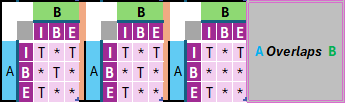

In [96]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
#mid_relations

#### Confines Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.

  
![Confines cylinder](FreeCAD_Scripts/confines_cylinder.png)



5. Match hole boundary slices for boundary tests:
   - For each hole boundary slice of the Primary ROI, if the slice has a Secondary contour, select that contour for comparison.
   - If the slice does not have a Secondary contour, identify the neighbouring slice that also has a hole.
   - If the neighbouring slice has a Secondary contour, select that contour.
   - If the neighbouring slice does not have a Secondary contour, boundary testing is not required.


  

In [1]:
def confines_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # cylinder with interior borders
    confines_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole,
                            confines_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#### Concentric cylinders ending on the same slice.

<img src="Images\Boundaries\PartitionInf3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\PartitionInf2D.png" alt="PartitionInf2D" style="height:30px;">

In [26]:
def concentric_cylinders_same_end():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    inf_partition = make_vertical_cylinder(roi_num=3, radius=1, length=0.4,
                                           offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, inf_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(concentric_cylinders_same_end(), [1, 3]))


- Concentric cylinders starting and ending on the same slice.

<img src="Images\Boundaries\Partition3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\Partition2D.png" alt="PartitionInf2D" style="height:30px;">

In [27]:
def concentric_cylinders_same_height():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting and ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    mid_partition = make_vertical_cylinder(roi_num=4, radius=1, length=0.7,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, mid_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(concentric_cylinders_same_height(), [1, 4]))


### Exterior Borders
  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.

      
![Exterior Border SUP](Images/Boundaries/ExteriorBorders2D_SUP.png)
![Exterior Border INF](Images/Boundaries/ExteriorBorders2D_INF.png)

In [28]:
def stacked_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    outside_cylinder = make_vertical_cylinder(roi_num=5, radius=2, length=0.4,
                                              offset_z=-0.4,
                                              spacing=slice_spacing)
    inside_cylinder = make_vertical_cylinder(roi_num=6, radius=1, length=0.4,
                                             offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, outside_cylinder, inside_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(stacked_cylinders(), [5, 6]))


### Interior Borders
  - Primary: Central Cylinder
  - Concentric shorter hole in the center of the primary cylinder
  - Secondary same height as hole but narrower
  - Interior borders at the and bottom of hole.
  
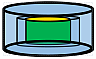
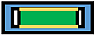

In [29]:
def embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=9, radius=4, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    center_hole = make_vertical_cylinder(roi_num=9, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=10, radius=1, length=0.5,
                                             offset_z=-0.2,
                                             spacing=slice_spacing)
    reference = make_vertical_cylinder(roi_num=11, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, center_hole, middle_cylinder, reference])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(embedded_cylinder(), [9, 10]))


- The `boundary_match` and `match_neighbour_slices` functions will need to be updated to include the hole boundary tests.
  - For hole boundaries, select the neighboring slice (s) that *DO* have a hole contour.
  - The Secondary slice selection works as usual.

In [30]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole, middle_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(dual_embedded_cylinder(), [1, 2]))


In [ ]:
def overlapping_cylinders():
    slice_spacing = 0.5
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two overlapping cylinders
    top_cylinder = make_vertical_cylinder(roi_num=7, radius=2, length=0.4, offset_z=-0.3, spacing=slice_spacing)
    bottom_cylinder = make_vertical_cylinder(roi_num=8, radius=2, length=0.4, offset_z=0, spacing=slice_spacing)
   # combine the contours
    slice_data = pd.concat([top_cylinder, bottom_cylinder, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(overlapping_cylinders(), [7, 8]))


# More Tests Needed

  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
- **Partition**
  - Concentric cylinders ending on the same slice.
  - Concentric cylinders starting on the same slice
  - Primary: Central Cylinder
    - Single Secondary slice with circular contour on the SUP/INF slice of the Primary cylinder.
  - Single Primary slice with circular contour
    - Secondary: one of:
      - SUP Cylinder ending on the same slice.
      - INF Cylinder ending on the same slice.
- **CONTAINS**
  - Concentric cylinders with interior cylinder ending inside the exterior cylinder by one slice
**OVERLAPS**
  - Concentric cylinders with interior cylinder ending outside the exterior cylinder by one slice
  - Concentric cylinders with interior cylinder consisting of single slice ending inside the exterior cylinder by one slice


  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.
  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
